# 2020 Presidential Election Time Series
## Project Setup

In [1]:
import os
from git import Repo
from bs4 import BeautifulSoup
import re
from datetime import datetime, timedelta
import time
import pytz
import numpy as np
import pandas as pd

### Timezone info and HTML tags for Data on Election Project site

In [2]:
# Add Election Project as remote source on Repo, remote:https://github.com/ElectProject/Early-Vote-2020G.git
repo_path = '.\Early-Vote-2020G'
cloned_repo = Repo(path=repo_path)
# Add html path containing data
html_path = 'docs/index.html'
# Tags for sparsing HTML data
date_slice_start, date_slice_end = len('Last updated: '),-len(' Eastern Time')
timezone = pytz.timezone('US/Eastern')
topline_ids = ['total-mail-ballots-returned-or-in-person-early-votes', 'mail-ballots-requested']
table_ids = ['voted-mail-ballots-by-party-registration', 'mail-ballots-requested-by-party-registration']
cast_str = re.compile(r'Voters have cast a total of')
request_str = [re.compile(r'Voters have requested a total of'), re.compile(r'There are a total of ')]
# DataFrame empty list initialization and columns names

totals_pkl_file = '2020_vote_totals.pkl'

In [64]:
totals_pkl_file[-4:]

'.pkl'

In [3]:
for entry in os.scandir():
    if not entry.name.startswith('.') and entry.is_dir():
        print('repo_path: {}'.format(entry.path))

repo_path: .\Early-Vote-2020G


In [81]:
print('Repo: \'{}\': {}\nTotal commits: {}\n{} commits: {}'.format(cloned_repo.remotes.origin.name, 
                                                                   cloned_repo.remotes.origin.url, 
                                                                   len(list(cloned_repo.iter_commits('master'))), 
                                                                   html_path, 
                                                                   len(list(cloned_repo.iter_commits('master', paths=html_path)))
                                                                  ))

Repo: 'origin': https://github.com/ElectProject/Early-Vote-2020G.git
Total commits: 876
docs/index.html commits: 364


### Fetch Data from Election Project

In [69]:
def get_commits(repo):
    repo.remotes.origin.fetch()
    # cloned_repo.heads.master.tracking_branch()
    repo.remotes.origin.pull()
    commits_list = list(cloned_repo.iter_commits('master', paths=html_path))
    return commits_list

In [70]:
def totals_init(data=''):
    totals_list = []
    totals_cols = ['commit','datetime','vote_id','vote_total', 'request_id', 'request_total']
    if data[-4:]=='.pkl':
        try:
            df = pd.read_pickle(pkl_file)
        except:
            df = pd.DataFrame(totals_list,columns=totals_cols)
    else:
        df = pd.DataFrame(totals_list,columns=totals_cols)
    return df

In [71]:
def get_data(repo, pkl_file):
    commits = get_commits(repo)
    df = totals_init(pkl_file)
    for c in commits:
        if c.hexsha not in df['commit']:
            soup = BeautifulSoup(c.tree[html_path].data_stream.read(), 'html.parser')    
            file_datetime = soup.find(text=re.compile(r'Last updated: '))[date_slice_start:date_slice_end]
            pd_datetime = timezone.localize(datetime.strptime(file_datetime, '%m/%d/%Y %I:%M %p'))

            t_dict = None
            total_cast = None
            cast_tag_id = None
            total_request = None
            request_tag_id = None
            req_str = None

#             print('hash: {}\npath: {}\ndatetime: {}'.format(c.hexsha, c.tree[html_path].path, file_datetime))

            try:
                total_cast = int(soup.find(text=cast_str).parent.strong.text.replace(',', ''))                
            except:
                total_cast = np.nan

            if total_cast != np.nan:
                try:
                     cast_tag_id = soup.find(text=cast_str).parent.parent['id']
                except:
                    cast_tag_id = np.nan
            else:
                cast_tag_id = np.nan


            try:
                total_request = int(soup.find(text=request_str[0]).parent.strong.text.replace(',', ''))
                req_str = request_str[0]
            except:
                try:
                    total_request = int(soup.find(text=request_str[1]).parent.strong.text.replace(',', ''))
                    req_str=request_str[1]
                except:
                    total_request = np.nan

            if total_request != np.nan and req_str != None:
                try:
                    request_tag_id = soup.find(text=req_str).parent.parent['id']
                except:
                    request_tag_id = np.nan
            else:
                request_tag_id = np.nan

            t_dict = {'commit':c.hexsha,'datetime':pd_datetime,'vote_id':cast_tag_id,'vote_total':total_cast, 'request_id':request_tag_id, 'request_total':total_request}
            df = df.append(t_dict, ignore_index=True)
    return df

In [193]:
df_totals = get_data(cloned_repo, totals_pkl_file)
df_totals

,commit,datetime,vote_id,vote_total,request_id,request_total
0,9ac0c1283530bfb74b3244163186990cbcf8f809,2020-10-19 13:35:00-04:00,total-voted,29147064,mail-ballots-requested,82521750
1,776204f9a1285b4f1876b3b6ce7de0dab18f3e40,2020-10-19 12:46:00-04:00,total-voted,29013562,mail-ballots-requested,82493331
2,8c178ae4095c40b65613ae8bf97e33b42fe80ddc,2020-10-19 10:59:00-04:00,total-voted,28760256,mail-ballots-requested,82399903
3,ad93a5814bdfa8e55aaf19f32e9fdf6e8c45fb47,2020-10-19 10:03:00-04:00,total-voted,28626265,mail-ballots-requested,82052581
4,5db8fd6aeba4a8569383a0eef9e4ce3f825b28bd,2020-10-19 09:15:00-04:00,total-voted,28439347,mail-ballots-requested,81998794
...,...,...,...,...,...,...
361,55ef4d8da4c860460a99cff8d2e7dac0605a857d,2020-09-01 22:55:00-04:00,NaN,NaN,NaN,12743272
362,ff3f92d8e11b8a23335cddf64e5799c74912ec52,2020-09-01 22:08:00-04:00,NaN,NaN,NaN,12623324
363,52ba37e4bd3605ab83b71358536ddf26d54b395d,2020-09-01 20:43:00-04:00,NaN,NaN,national-statistics,12623324
364,d34181643d565305eff7486090acbe9329c48d31,2020-09-01 15:48:00-04:00,NaN,NaN,national-statistics,12623324


In [75]:
# http://www.electproject.org/early_2016
# 09/25/16 https://www.huffpost.com/entry/2016-early-voting-underwa_b_12184290 9,525 
# 10/02/16 https://www.huffpost.com/entry/early-in-the-early-voting_b_12303146 74,836
# 10/09/16 https://www.huffpost.com/entry/early-voting-a-month-to-g_b_12424562 429,337
# 10/16/16 https://www.huffpost.com/entry/early-voting-more-states_b_12517738 1,400,000
# 10/23/16 https://www.huffpost.com/entry/early-voting-the-election_b_12614284 5,900,000
# 10/30/16 https://www.huffpost.com/entry/early-voting-stability-de_b_12723188 21,000,000
# 11/02/16 https://docs.google.com/spreadsheets/d/1fz_V3oAUL8XJMEudq5wm5hDT_f554uagt6sIm_sJDro/edit?usp=sharing 46,220,922
# 11/03/16 https://docs.google.com/spreadsheets/d/1fz_V3oAUL8XJMEudq5wm5hDT_f554uagt6sIm_sJDro/edit?usp=sharing total votes without write-ins 128,925,332
# 11/03/16 https://ballotpedia.org/Presidential_election,_2016 136,452,15

vote_2016_dict = {'datetime':
                  ['09/25/2016 10:59 PM', '10/02/2016 10:59 PM', '10/09/2016 10:59 PM', '10/16/2016 10:59 PM', '10/23/2016 10:59 PM', '10/30/2016 10:59 PM', '11/02/2016 10:59 PM', '11/03/2016 10:59 PM'], 
                  'vote_total_2016':
                  [9525 , 74836, 429337, 1400000, 5900000, 21000000, 46220922, 136452150]}

In [194]:
df_2016_totals = pd.DataFrame.from_dict(vote_2016_dict)
df_2016_totals['datetime'] = df_2016_totals['datetime'].apply(lambda x: timezone.localize(datetime.strptime(x, '%m/%d/%Y %I:%M %p'))) + pd.DateOffset(years=4)
df_2016_totals

,datetime,vote_total_2016
0,2020-09-25 22:59:00-04:00,9525
1,2020-10-02 22:59:00-04:00,74836
2,2020-10-09 22:59:00-04:00,429337
3,2020-10-16 22:59:00-04:00,1400000
4,2020-10-23 22:59:00-04:00,5900000
5,2020-10-30 22:59:00-04:00,21000000
6,2020-11-02 22:59:00-05:00,46220922
7,2020-11-03 22:59:00-05:00,136452150


In [195]:
xplt_end = timezone.localize(datetime.strptime('11/04/2020 11:59 PM', '%m/%d/%Y %I:%M %p'))
election_day = timezone.localize(datetime.strptime('11/03/2020 11:59 PM', '%m/%d/%Y %I:%M %p'))
election_start = df_totals['datetime'].min()
date_limits = [election_start, xplt_end]

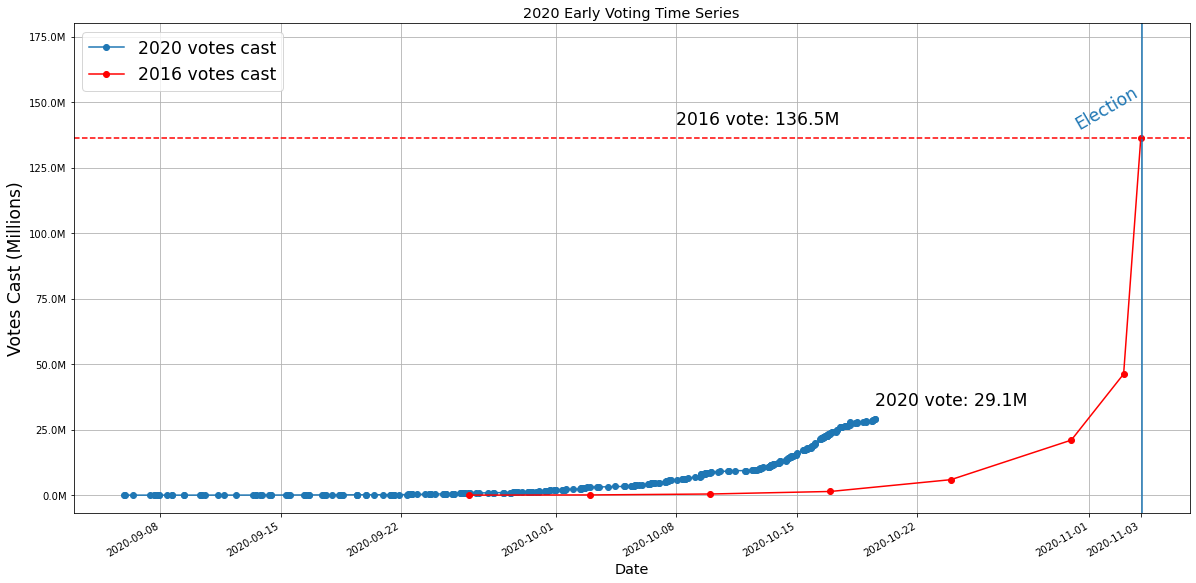

In [196]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# https://python-graph-gallery.com/
fig, ax = plt.subplots(figsize=(20, 10))
dates = df_totals['datetime']
values = df_totals['vote_total']

dates_2016 = df_2016_totals['datetime']
values_2016 = df_2016_totals['vote_total_2016']

ax.plot(dates, values, 'o-', label='2020 votes cast')
ax.plot(dates_2016, values_2016, 'ro-', label='2016 votes cast')

plt.title('2020 Early Voting Time Series', size='x-large')
plt.xlabel('Date', size='x-large')
plt.ylabel('Votes Cast (Millions)', size='xx-large')
ax.legend(fontsize='xx-large')
ax.grid(True)

# https://matplotlib.org/3.3.1/gallery/ticks_and_spines/tick-formatters.html
# see also millify https://github.com/azaitsev/millify
ax.yaxis.set_major_formatter(lambda x, pos: '{:1.1f}M'.format(x*1e-6)) 
ylim=int(180*1e6)
ax.set_xlim(right=datetime(2020, 11, 7))
ax.set_ylim(top=ylim)

ax.axvline(x=election_day, color='#1f77b4')


level_2016=[ax.get_xticks()[4],mdates.date2num(max(dates_2016))]
ax.axhline(y=max(values_2016), ls='--', color='red')
# ax.plot(level_2016, [max(values_2016),max(values_2016)], "--", color="r", markerfacecolor="w")
ax.annotate('2016 vote: {:1.1f}M'.format(max(values_2016)*1e-6),(level_2016[0],max(values_2016)+.5e7),size='xx-large')

ax.annotate('2020 vote: {:1.1f}M'.format(max(values)*1e-6),(mdates.date2num(max(dates)),max(values)+.5e7),size='xx-large')

plt.text(x=(election_day-timedelta(days=4)), y=14*1e7, s='Election', rotation=30, color='#1f77b4', size='xx-large')
ax.set_xticks(list(ax.get_xticks()) + [18570.16666667])
plt.setp(ax.get_xticklabels()[-1], x=election_day, y=0, text='2020-11-03')

fig.autofmt_xdate()

plt.show()

In [197]:
df_totals.to_pickle('2020_vote_totals.pkl')

In [198]:
fig.savefig('2020_vs_2016_votes.png')
fig.savefig('2020_vs_2016_votes.jpg')

In [199]:
# http://docs.bokeh.org/en/1.0.2/docs/user_guide/examples/tools_hover_tooltip_formatting.html
# https://docs.bokeh.org/en/latest/docs/user_guide/quickstart.html
# https://stackoverflow.com/questions/41380824/python-bokeh-hover-date-time
# https://stackoverflow.com/questions/48792770/bokeh-hovertool-tooltips-showing-date-as-number
# https://docs.bokeh.org/en/latest/docs/reference/models/tools.html?highlight=line_policy#bokeh.models.tools.HoverTool.line_policy
# https://docs.bokeh.org/en/latest/docs/user_guide/interaction/callbacks.html?highlight=hit%20tool
# https://stackoverflow.com/questions/36434562/displaying-only-one-tooltip-when-using-the-hovertool-tool
from bokeh.plotting import figure, output_file, show
from bokeh.models import ColumnDataSource, HoverTool, CrosshairTool, NumeralTickFormatter, Range1d
from bokeh.io import output_notebook

output_file("2020_v_2016_votes_cast.html")
output_notebook()

p = figure(plot_height=250, x_axis_type="datetime", tools="", toolbar_location=None,
           title="2020 Votes Cast", sizing_mode="scale_width", y_range=Range1d(int(-8*1e5),int(18*1e7)))

p.background_fill_color="#f5f5f5"
p.grid.grid_line_color="white"
p.xaxis.axis_label = 'Date'
p.yaxis.axis_label = 'Votes'
p.axis.axis_line_color = None

data_date_max = source = ColumnDataSource(data={
    'max_date' : df_totals.groupby(by=[df_totals.datetime.dt.date]).vote_total.max().index,
    'vote_date_total' : df_totals.groupby(by=[df_totals.datetime.dt.date]).vote_total.max()
})

# v2020 = p.line(x='datetime', y='vote_total', line_width=2, color='#ebbd5b', source=df_totals)
v2020 = p.line(x='max_date', y='vote_date_total', line_width=2, source=data_date_max)
v2016 = p.line(x='datetime', y='vote_total_2016', line_width=2, color='red', source=df_2016_totals)

# custom_filter = CustomJSFilter(code='''
# var indices = [];

# // iterate through rows of data source and see if each satisfies some constraint
# for (var i = 0; i < source.get_length(); i++){
#     if (source.data['datetime'][i] == 'some_value'){
#         indices.push(true);
#     } else {
#         indices.push(false);
#     }
# }
# return indices;
# ''')

hover_2020 = HoverTool(renderers=[v2020],
    tooltips=[
        ( 'date',   '@max_date{%m/%d/%Y}'            ), # {%F}
#         ( '2016 votes',  '@vote_total_2016{0.0a}' ), # {:1.1f}M
        ( '2020 votes', '@vote_date_total{0.0a}'      ) # {:1.1f}M {0.0a} @vote_date_total
#         ( '2020 votes', '@vote_total{:1.1f}M'      ),
    ],
    line_policy='nearest',
    formatters={
        '@max_date'        : 'datetime', # use 'datetime' formatter for '@date' field
#         '@2016 votes' : 'numeral',   # use 'printf' formatter for '@{adj close}' field
        '@vote_date_total' : 'numeral' # use default 'numeral' formatter for other fields
#         '@2020 votes' : 'printf' # use default 'numeral' formatter for other fields
    },
    # display a tooltip whenever the cursor is vertically in line with a glyph
    mode='vline', # 'mouse'
    attachment='above'
#     anchor='top_center'
)

hover_2016 = HoverTool(renderers=[v2016],
    tooltips=[
        ( 'date',   '@datetime{%m/%d/%Y}'            ), # {%F}
        ( '2016 votes',  '@vote_total_2016{0.0a}' ), # {:1.1f}M
#         ( '2020 votes', '@vote_date_total{0.0a}'      ) # {:1.1f}M {0.0a} @vote_date_total
#         ( '2020 votes', '@vote_total{:1.1f}M'      ),
    ],
    line_policy='nearest',
    formatters={
        '@datetime'        : 'datetime', # use 'datetime' formatter for '@date' field
        '@2016 votes' : 'numeral',   # use 'printf' formatter for '@{adj close}' field
#         '@vote_date_total' : 'numeral' # use default 'numeral' formatter for other fields
#         '@2020 votes' : 'printf' # use default 'numeral' formatter for other fields
    },
    # display a tooltip whenever the cursor is vertically in line with a glyph
    mode='vline', # 'mouse',
#     anchor='bottom_center',
#     point_policy='snap_to_data'
    attachment='below'
)

cross = CrosshairTool(dimensions='height')
p.yaxis.formatter=NumeralTickFormatter(format='0.0a')
p.add_tools(hover_2020)
p.add_tools(hover_2016)
p.add_tools(cross)

show(p)

Loading BokehJS ...

# To-Do
## code cleanup
* move Election Project git folder outside project or add as remote with single file tracking
* move To-Do to separate md file
* move scratch to separate .ipynb file
* organize functions / code sections
* separate check for if commit has data for each total cast, percent of 2016, mail requests, and tables
* move git pull to data update loop
* tqdm for data update
* compile table subsets
* error handling

## additional data
* voter general turnout [cumulative sum time series] 2020 vs 2018 vs 2016 (Election Project, MIT, Harvard data, etc.)
* voter general turnout [% of previous year time series] 2020 vs 2018 vs 2016 (Election Project)
* voter general registration [cumulative sum time series] 2020 vs 2018 vs 2016 (Election Project, Census, States, Orgs, etc.)
* voter general mail requests [cumulative sum time series] 2020 vs 2018 vs 2016 (Election Project)
* voter enthusiasm [cumulative sum time series] 2020 vs 2018 vs 2016 (Pew), [Gallup](https://news.gallup.com/poll/321599/voter-turnout-appears-steady-enthusiasm-running-high.aspx)
* https://docs.cdn.yougov.com/1ace2lgidt/econTabReport.pdf
* https://www.pewresearch.org/politics/2020/10/09/voter-engagement-and-interest-voting-by-mail-and-in-person/
* https://www.langerresearch.com/wp-content/uploads/1218a12020ElectionUpdate.pdf
* total population [annual value] 2020 (estimates) vs 2018 vs 2016 (Census, etc.)
* population growth [annual % of previous year value] 2020 (estimates) vs 2018 vs 2016 (Census, etc.)
* eligible voters [annual value] 2020 (estimates) vs 2018 vs 2016 [Census CVAP](https://www.census.gov/programs-surveys/decennial-census/about/voting-rights/cvap.html), [Wikipedia US Voter Turnout](https://en.wikipedia.org/wiki/Voter_turnout_in_the_United_States_presidential_elections)
* voter primary turnout [cumulative sum time series] 2020 vs 2018 vs 2016 (?)
* daily delta (make stationary?)
* ln applied to daily delta
    
## visual updates
* ~chart y scale number format~
* ~chart vertical line for election day~
* ~chart legend~
* ~chart marker on dates states start voteing
    - [Line markers](https://matplotlib.org/3.3.2/gallery/lines_bars_and_markers/timeline.html#sphx-glr-gallery-lines-bars-and-markers-timeline-py)~
* chart UI widgets to adjust data, zoom, mouse over
    - [Bokeh](https://docs.bokeh.org/en/latest/docs/user_guide/quickstart.html), [Bokeh Embed](https://docs.bokeh.org/en/latest/docs/user_guide/embed.html), [Bokeh crosshair, hover.tooltip](https://docs.bokeh.org/en/latest/docs/user_guide/tools.html)
    - [mpld3](https://mpld3.github.io/examples/interactive_legend.html), [mpld3 save to html](https://mpld3.github.io/modules/API.html#mpld3.save_html)
    - [Holoview](http://holoviews.org/getting_started/Introduction.html), [Holoview save](http://holoviews.org/user_guide/Plots_and_Renderers.html)
    - [plotly python](https://plotly.com/python/), [plotly embeded](https://plotly.com/python/interactive-html-export/)
    - [bqplot](https://bqplot.readthedocs.io/en/latest/introduction.html)
    - [pygal](http://www.pygal.org/en/latest/installing.html)
* ploting libraries
    - [seaborn](https://seaborn.pydata.org/introduction.html)
    - [ggplot](https://yhat.github.io/ggpy/)
* code markdown headings
* citations
    
    